## **Model 2 : Normalization to baseline**

**Load and resize**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Dataset with normalization
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

train_dir = "datasets/Training"
test_dir  = "datasets/Testing"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


**Validation split**

In [2]:
val_size = int(0.2 * len(train_ds))
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

**Normalize to [0,1]**

In [3]:
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

**Build CNN (same as Model 1)**

In [22]:
def build_cnn(input_shape=(128,128,3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model2 = build_cnn()
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

**Compile**

In [23]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

**Train**

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='models/model02_best.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Train with callbacks
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,   # give more epochs, EarlyStopping will halt earlier
    callbacks=callbacks
)

best_model2 = tf.keras.models.load_model('models/model02_best.h5')


Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6125 - loss: 0.8963
Epoch 1: val_loss improved from None to 0.39121, saving model to models/model02_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 30s 188ms/step - accuracy: 0.7284 - loss: 0.6738 - val_accuracy: 0.8527 - val_loss: 0.3912 - learning_rate: 0.0010
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8548 - loss: 0.3951
Epoch 2: val_loss did not improve from 0.39121
144/144 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.8693 - loss: 0.3625 - val_accuracy: 0.8634 - val_loss: 0.4089 - learning_rate: 0.0010
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9026 - loss: 0.2754
Epoch 3: val_loss improved from 0.39121 to 0.23350, saving model to models/model02_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.9129 - loss: 0.2463 - val_accuracy: 0.9187 - val_loss: 0.2335 - learning_rate: 0.0010
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9422 - loss: 0.1634
Epoch 4: val_loss improved from 0.23350 to 0.22410, saving model to models/model02_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 25s 175ms/step - accuracy: 0.9514 - loss: 0.1390 - val_accuracy: 0.9250 - val_loss: 0.2241 - learning_rate: 0.0010
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9689 - loss: 0.0969
Epoch 5: val_loss did not improve from 0.22410
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 165ms/step - accuracy: 0.9721 - loss: 0.0871 - val_accuracy: 0.9161 - val_loss: 0.2748 - learning_rate: 0.0010
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9712 - loss: 0.0852
Epoch 6: val_loss did not improve from 0.22410
144/144 ━━━━━━━━━━━━━━━━━━━━ 25s 171ms/step - accuracy: 0.9728 - loss: 0.0808 - val_accuracy: 0.9286 - val_loss: 0.2276 - learning_rate: 0.0010
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9806 - loss: 0.0599
Epoch 7: val_loss did not improve from 0.22410

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 165ms/step - accuracy: 0.9843 - loss: 0.0470 - val_ac

**Evaluate**

In [ ]:
# Evaluate on test set
test_loss, test_acc = model2.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Get final training & validation metrics
final_train_acc = history2.history['accuracy'][-1]
final_train_loss = history2.history['loss'][-1]
final_val_acc   = history2.history['val_accuracy'][-1]
final_val_loss  = history2.history['val_loss'][-1]

print(f"Final training accuracy: {final_train_acc:.4f}")
print(f"Final training loss: {final_train_loss:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")
print(f"Final validation loss: {final_val_loss:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9169 - loss: 0.2335
Test accuracy: 0.9169
Test loss: 0.2335
Final training accuracy: 0.9989
Final training loss: 0.0059
Final validation accuracy: 0.9527
Final validation loss: 0.2391


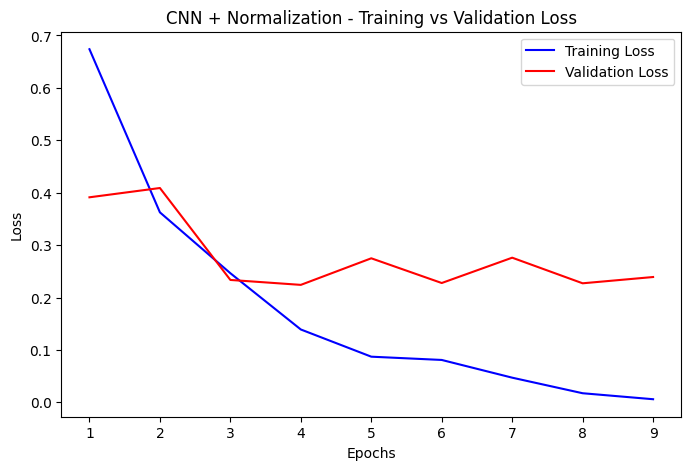

In [26]:
import matplotlib.pyplot as plt

def plot_loss_curves(history, model_name="Model"):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call for Model 2
plot_loss_curves(history2, model_name="CNN + Normalization")

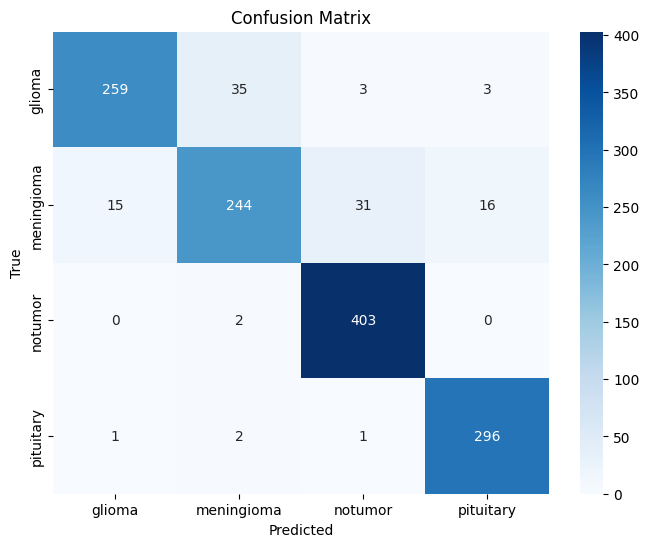


Classification Report:

              precision    recall  f1-score   support

      glioma       0.94      0.86      0.90       300
  meningioma       0.86      0.80      0.83       306
     notumor       0.92      1.00      0.96       405
   pituitary       0.94      0.99      0.96       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



In [5]:
from plot_utils import plot_confusion_matrix_from_dataset

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion matrix from saved model
plot_confusion_matrix_from_dataset("models/model02_best.h5", test_ds, class_names)
